# Proyek Machine Learning: Sistem Rekomendasi Game Steam

## Import Library



In [1]:
!pip install tensorflow
!pip install graphviz
!pip install pydot
# Library umum
import shutil
import os
import zipfile
from ast import literal_eval
import kagglehub
import warnings
warnings.filterwarnings('ignore')
import pydot
import graphviz
# Library Visualisasi dan analisis Data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

# Library deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Library pemrosesan dan metrik
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.0 MB/s eta 0:00:00


In [2]:

files.upload()

!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d antonkozyriev/game-recommendations-on-steam --force
!unzip game-recommendations-on-steam.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam
License(s): CC0-1.0
 87% 577M/660M [00:00<00:00, 1.20GB/s]
100% 660M/660M [00:00<00:00, 1.20GB/s]
Archive:  game-recommendations-on-steam.zip
  inflating: games.csv               
  inflating: games_metadata.json     
  inflating: recommendations.csv     
  inflating: users.csv               


## Data Loading

In [3]:
game_df = pd.read_csv('games.csv')
user_df = pd.read_csv('users.csv')
recommend_df = pd.read_csv('recommendations.csv')
games_metadata_df = pd.read_json('games_metadata.json', lines=True)


Melakukan drop data yang mengalami missing value

## Eksplorasi Data dan Visualisasi (EDA)

## Deksripsi Data

In [4]:
games_metadata_df.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


In [5]:
games_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_id       50872 non-null  int64 
 1   description  50872 non-null  object
 2   tags         50872 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [6]:
games_metadata_df.describe()

,app_id
count,5.087200e+04
mean,1.055224e+06
std,6.103249e+05
min,1.000000e+01
25%,5.287375e+05
50%,9.860850e+05
75%,1.524895e+06
max,2.599300e+06


In [7]:
game_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


In [8]:
game_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int64  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int64  
 8   user_reviews    50872 non-null  int64  
 9   price_final     50872 non-null  float64
 10  price_original  50872 non-null  float64
 11  discount        50872 non-null  float64
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float64(3), int64(3), object(3)
memory usage: 3.7+ MB


In [9]:
game_df.describe()

,app_id,positive_ratio,user_reviews,price_final,price_original,discount
count,5.087200e+04,50872.000000,5.087200e+04,50872.000000,50872.000000,50872.000000
mean,1.055224e+06,77.052033,1.824425e+03,8.620325,8.726788,5.592212
std,6.103249e+05,18.253592,4.007352e+04,11.514164,11.507021,18.606679
min,1.000000e+01,0.000000,1.000000e+01,0.000000,0.000000,0.000000
25%,5.287375e+05,67.000000,1.900000e+01,0.990000,0.990000,0.000000
50%,9.860850e+05,81.000000,4.900000e+01,4.990000,4.990000,0.000000
75%,1.524895e+06,91.000000,2.060000e+02,10.990000,11.990000,0.000000
max,2.599300e+06,100.000000,7.494460e+06,299.990000,299.990000,90.000000


In [10]:
user_df.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


In [11]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 327.4 MB


In [12]:
user_df.describe()

,user_id,products,reviews
count,1.430606e+07,1.430606e+07,1.430606e+07
mean,7.153032e+06,1.163734e+02,2.876738e+00
std,4.129805e+06,2.438515e+02,7.987421e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.576516e+06,2.300000e+01,1.000000e+00
50%,7.153032e+06,5.500000e+01,1.000000e+00
75%,1.072955e+07,1.270000e+02,3.000000e+00
max,1.430606e+07,3.221400e+04,6.045000e+03


In [13]:
recommend_df.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


In [14]:
recommend_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB


In [15]:
recommend_df.describe()

,app_id,helpful,funny,hours,user_id,review_id
count,4.115479e+07,4.115479e+07,4.115479e+07,4.115479e+07,4.115479e+07,4.115479e+07
mean,6.032724e+05,3.202567e+00,1.058071e+00,1.006022e+02,7.450576e+06,2.057740e+07
std,4.729233e+05,4.693649e+01,2.867060e+01,1.761675e+02,4.010685e+06,1.188037e+07
min,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.539400e+05,0.000000e+00,0.000000e+00,7.800000e+00,4.287256e+06,1.028870e+07
50%,4.351500e+05,0.000000e+00,0.000000e+00,2.730000e+01,7.546446e+06,2.057740e+07
75%,9.331100e+05,0.000000e+00,0.000000e+00,9.920000e+01,1.096877e+07,3.086609e+07
max,2.253290e+06,3.621200e+04,2.810900e+04,1.000000e+03,1.430606e+07,4.115479e+07


In [16]:
dataframes = {
    'game_df' : game_df,
    'users_df' : user_df,
    'recommend_df' : recommend_df,
    'games_metadata_df': games_metadata_df
}

# Checking null values
for name, df in dataframes.items():
    print(f"\nNull values in {name} :\n{df.isna().sum()}")

    # Dimension of dataframe
    df_dimension = df.shape

    print(f"Dimension of {name}: {df_dimension}")



Null values in game_df :
app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64
Dimension of game_df: (50872, 13)

Null values in users_df :
user_id     0
products    0
reviews     0
dtype: int64
Dimension of users_df: (14306064, 3)

Null values in recommend_df :
app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64
Dimension of recommend_df: (41154794, 8)

Null values in games_metadata_df :
app_id         0
description    0
tags           0
dtype: int64
Dimension of games_metadata_df: (50872, 3)


In [17]:
n_games = game_df.nunique()
n_users = user_df.nunique()

unique_review_values = recommend_df['is_recommended'].unique()

print('\nNumber of unique values in game_df: ', n_games)

print('Number of unique values in users_df: ', n_users)
print("Unique Review values (is_recommended) : ", unique_review_values)



Number of unique values in game_df:  app_id            50872
title             50751
date_release       4292
win                   2
mac                   2
linux                 2
rating                9
positive_ratio      100
user_reviews       4847
price_final         436
price_original      183
discount             75
steam_deck            2
dtype: int64
Number of unique values in users_df:  user_id     14306064
products        7572
reviews          681
dtype: int64
Unique Review values (is_recommended) :  [ True False]


## Unvariate Analysis

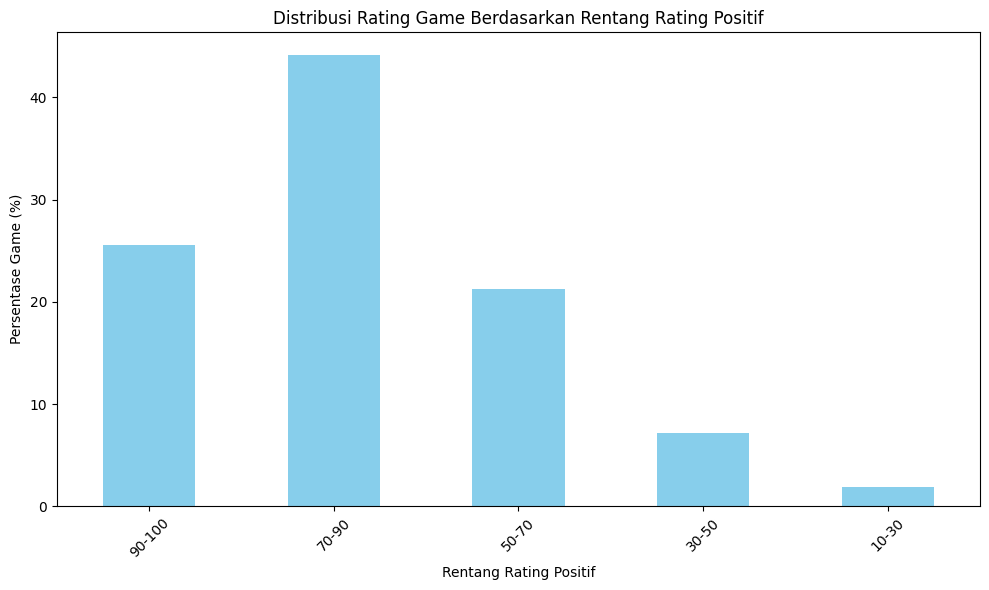

In [18]:

# Menentukan rentang rating yang ingin dikelompokkan (dimulai dari 10)
bins = [10, 30, 50, 70, 90, 100]  # Batasan rentang rating
labels = ['10-30', '30-50', '50-70', '70-90', '90-100']  # Label untuk setiap rentang

# Mengelompokkan data berdasarkan rentang rating
game_df['rating_group'] = pd.cut(game_df['positive_ratio'], bins=bins, labels=labels, right=False)

# Menghitung jumlah game di setiap kelompok
rating_distribution = game_df['rating_group'].value_counts(normalize=True) * 100  # Menghitung persentase

# Menentukan urutan kategori yang diinginkan pada sumbu X
rating_distribution = rating_distribution[['90-100', '70-90', '50-70', '30-50', '10-30']]

# Menampilkan distribusi rating dalam bentuk bar chart
plt.figure(figsize=(10, 6))
rating_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribusi Rating Game Berdasarkan Rentang Rating Positif')
plt.xlabel('Rentang Rating Positif')
plt.ylabel('Persentase Game (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Insight:

1. **Rentang Rating 70-90**  
   Rating **70-90** merupakan rentang rating yang paling banyak ditemui, dengan persentase tertinggi sekitar **40%**. Ini menunjukkan bahwa sebagian besar game mendapatkan ulasan positif, tetapi tidak sepenuhnya mendapatkan rating luar biasa. Banyak game yang cukup sukses namun tidak mencapai kualitas yang sangat luar biasa di mata pemain.

2. **Rentang Rating 90-100**  
   Disusul oleh rating **90-100** dengan persentase sekitar **20%**. Ini menunjukkan bahwa sejumlah game berhasil mendapatkan penerimaan luar biasa dari pemain, menandakan kualitas gameplay, grafis, dan dukungan teknis yang sangat memuaskan.

3. **Rentang Rating 50-70**  
   Rating **50-70** mengikutinya dengan persentase sekitar **15%**. Hal ini menunjukkan bahwa ada sebagian kecil game yang mendapatkan penilaian cukup baik, namun masih ada ruang untuk perbaikan dalam hal fitur atau gameplay untuk memuaskan lebih banyak pemain.

4. **Rentang Rating 30-50**  
   Rentang **30-50** mencatat sekitar **10%** game. Ini menunjukkan bahwa ada game yang dianggap cukup biasa atau memiliki kekurangan yang signifikan dalam hal kualitas atau pengalaman pengguna.

5. **Rentang Rating 10-30**  
   Rentang **10-30** hanya mencatat sekitar **5%** game, menunjukkan bahwa sedikit sekali game yang menerima rating sangat rendah. Game dengan rating ini kemungkinan besar memiliki masalah yang sangat mendalam, seperti bug besar atau desain yang buruk.

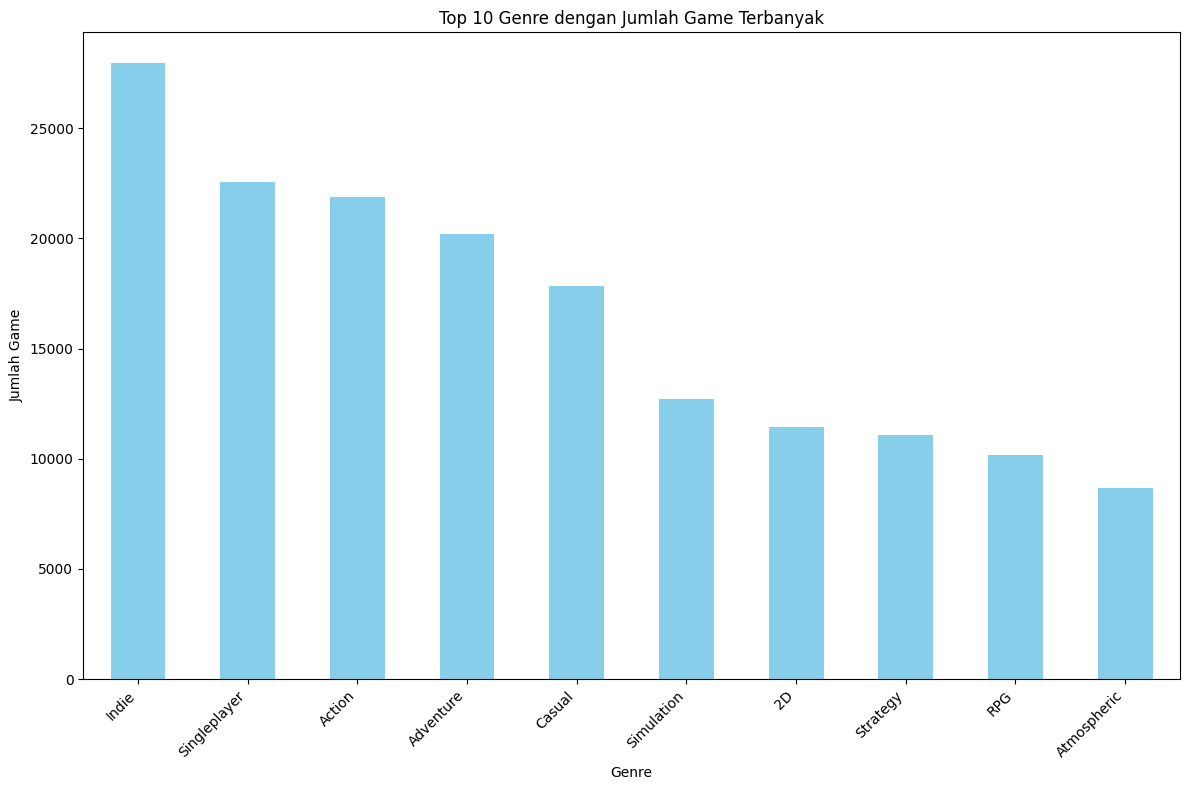

In [19]:
# Menggabungkan games_df dan games_metadata_df berdasarkan 'app_id' sebagai foreign key
games_with_metadata = pd.merge(game_df, games_metadata_df, on='app_id', how='left')

# Meledakkan genre-genre tersebut ke dalam baris-baris terpisah
exploded_genres = games_with_metadata.explode('tags')

# Membersihkan spasi di sekitar nama genre
exploded_genres['tags'] = exploded_genres['tags'].str.strip()

# Menghitung jumlah game di setiap genre
genre_distribution = exploded_genres['tags'].value_counts()

# Menampilkan top 10 genre berdasarkan jumlah game
top_10_genre_distribution = genre_distribution.head(10)

# Menampilkan distribusi jumlah game per genre dalam bentuk bar chart
plt.figure(figsize=(12, 8))
top_10_genre_distribution.plot(kind='bar', color='skyblue')
plt.title('Top 10 Genre dengan Jumlah Game Terbanyak')
plt.xlabel('Genre')
plt.ylabel('Jumlah Game')
plt.xticks(rotation=45, ha='right')  # Memutar label agar lebih mudah dibaca
plt.tight_layout()
plt.show()

**Insight:**

1. **Genre "Indie"**
   - **Genre "Indie"** merupakan genre dengan jumlah game terbanyak, dengan **lebih dari 25.000 game**. Ini menunjukkan bahwa genre ini sangat dominan di Steam, dengan banyak pengembang indie yang merilis game mereka di platform ini.
   - **Interpretasi**: Genre **Indie** menggambarkan tren dalam industri game, di mana banyak pengembang kecil dan independen yang berhasil meraih kesuksesan di platform digital. Ini juga mencerminkan bahwa pemain sangat tertarik dengan game kreatif dengan anggaran terbatas.

2. **Genre "Singleplayer"**
   - **Singleplayer** mencatatkan sekitar **20.000 game**, menjadikannya salah satu genre terpopuler di Steam. Genre ini menunjukkan bahwa banyak game yang berfokus pada pengalaman pemain tunggal.
   - **Interpretasi**: Kecenderungan ini menunjukkan bahwa banyak pemain lebih memilih pengalaman bermain yang mendalam, di mana mereka dapat menikmati cerita dan gameplay tanpa bergantung pada orang lain.

3. **Genre "Action"**
   - **Action** juga mencatatkan sekitar **20.000 game**, menjadikannya genre yang sangat banyak diminati. Genre ini menunjukkan banyaknya game dengan fokus pada aksi dan dinamika gameplay yang cepat.
   - **Interpretasi**: Genre **Action** sangat populer karena menawarkan pengalaman bermain yang intens dan mengasyikkan bagi para pemain yang mencari tantangan dan adrenalin.

4. **Genre "Adventure"**
   - **Adventure** berada di posisi keempat dengan lebih dari **15.000 game**. Genre ini berfokus pada eksplorasi dan cerita yang mendalam, yang memberikan pengalaman imersif bagi pemain.
   - **Interpretasi**: Genre **Adventure** mencerminkan popularitas game dengan cerita yang kuat dan dunia yang kaya, di mana pemain dapat merasakan petualangan dan pengembangan karakter yang mendalam.

5. **Genre "Casual"**
   - **Casual** mencatatkan lebih dari **10.000 game**, menunjukkan bahwa banyak pemain yang menikmati game dengan gameplay yang ringan dan mudah diakses.
   - **Interpretasi**: Genre **Casual** sangat populer di kalangan pemain yang mencari game yang tidak terlalu menuntut dan cocok dimainkan dalam waktu singkat.

6. **Genre "Simulation"**
   - **Simulation** dengan lebih dari **10.000 game** menunjukkan bahwa genre ini banyak diminati oleh pemain yang tertarik pada simulasi kehidupan atau sistem yang realistis.
   - **Interpretasi**: Genre **Simulation** menawarkan pengalaman bermain yang lebih santai dan kreatif, di mana pemain dapat menciptakan atau mengelola sesuatu sesuai dengan skenario tertentu.

7. **Genre "2D"**
   - **2D** muncul dengan lebih dari **5.000 game**. Genre ini berfokus pada gameplay dengan tampilan dua dimensi, menawarkan pengalaman yang lebih sederhana dan nostalgik.
   - **Interpretasi**: Genre **2D** tetap populer karena gameplay-nya yang mudah diakses dan fokus pada estetika dan desain yang unik.

8. **Genre "Strategy"**
   - **Strategy** memiliki lebih dari **5.000 game**, mencerminkan banyaknya game yang mengutamakan perencanaan dan taktik.
   - **Interpretasi**: Genre **Strategy** sangat dihargai oleh pemain yang menyukai tantangan mental dan pengambilan keputusan yang mendalam.

9. **Genre "RPG"**
   - **RPG (Role-Playing Game)** dengan lebih dari **5.000 game** juga menunjukkan bahwa genre ini memiliki audiens yang besar, dengan pengalaman bermain yang lebih berfokus pada cerita dan pengembangan karakter.
   - **Interpretasi**: Genre **RPG** sangat populer di kalangan pemain yang suka menjelajahi dunia fantasi dan membangun karakter mereka dari awal.

10. **Genre "Atmospheric"**
   - **Atmospheric** menempati posisi terakhir dengan lebih dari **5.000 game**, mengindikasikan banyaknya game yang menekankan pada suasana dan visual yang mendalam.
   - **Interpretasi**: Genre **Atmospheric** menarik pemain yang ingin merasakan pengalaman visual dan emosional yang lebih mendalam, dengan fokus pada atmosfer yang memengaruhi pengalaman gameplay secara keseluruhan.

## Data Preparation

In [20]:

# Jika perlu mengganti nilai yang tidak sesuai dalam kolom produk
user_df['products'] = user_df['products'].apply(lambda x: x if x > 0 else None)


# Menyaring nilai yang tidak valid (misalnya produk dan ulasan yang kosong atau tidak sesuai)
game_df.dropna(subset=['price_final', 'price_original'], inplace=True)
user_df.dropna(subset=['products'], inplace=True)

# 4. Verifikasi data setelah pembersihan
print("Cleaned data for game_df:")
print(game_df.head())
print("Cleaned data for users_df:")
print(user_df.head())

Cleaned data for game_df:
   app_id                              title date_release   win    mac  linux  \
0   13500  Prince of Persia: Warrior Within™   2008-11-21  True  False  False   
1   22364            BRINK: Agents of Change   2011-08-03  True  False  False   
2  113020       Monaco: What's Yours Is Mine   2013-04-24  True   True   True   
3  226560                 Escape Dead Island   2014-11-18  True  False  False   
4  249050            Dungeon of the ENDLESS™   2014-10-27  True   True  False   

          rating  positive_ratio  user_reviews  price_final  price_original  \
0  Very Positive              84          2199         9.99            9.99   
1       Positive              85            21         2.99            2.99   
2  Very Positive              92          3722        14.99           14.99   
3          Mixed              61           873        14.99           14.99   
4  Very Positive              88          8784        11.99           11.99   

   discount 

In [21]:

# Mengganti nilai kosong atau NaN di kolom 'description' dengan string kosong atau None
games_metadata_df['description'] = games_metadata_df['description'].apply(lambda x: x if pd.notnull(x) and x.strip() != '' else 'No Description')

# Mengganti array kosong pada kolom 'tags' dengan None atau list kosong
games_metadata_df['tags'] = games_metadata_df['tags'].apply(lambda x: x if len(x) > 0 else None)

# Memeriksa hasil setelah pembersihan
print(games_metadata_df.head())

# Menghapus baris dengan NaN di kolom 'tags' dan 'description'
games_metadata_df.dropna(subset=['tags', 'description'], inplace=True)

# Memeriksa hasil setelah drop NaN
print("Jumlah baris setelah pembersihan:", games_metadata_df.shape[0])
games_metadata_df

   app_id                                        description  \
0   13500  Enter the dark underworld of Prince of Persia ...   
1   22364                                     No Description   
2  113020  Monaco: What's Yours Is Mine is a single playe...   
3  226560  Escape Dead Island is a Survival-Mystery adven...   
4  249050  Dungeon of the Endless is a Rogue-Like Dungeon...   

                                                tags  
0  [Action, Adventure, Parkour, Third Person, Gre...  
1                                           [Action]  
2  [Co-op, Stealth, Indie, Heist, Local Co-Op, St...  
3  [Zombies, Adventure, Survival, Action, Third P...  
4  [Roguelike, Strategy, Tower Defense, Pixel Gra...  
Jumlah baris setelah pembersihan: 49628


,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,No Description,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."
...,...,...,...
50845,2455060,"In the rogue action game ""Taboo Trial"", you wi...","[RPG, Indie, Nudity, Action Roguelike, Female ..."
50847,1138640,"Build better, together 🏡 Hometopia is a seriou...","[Early Access, Life Sim, City Builder, Immersi..."
50848,2515460,No Description,"[Strategy, Indie, Simulation]"
50857,1687000,Seiji Maruyama is a middle-aged yakuza recentl...,"[Side Scroller, Beat 'em up, Sandbox, Martial ..."


In [22]:
game_df = game_df[['app_id','title','positive_ratio']]
games_metadata_df = games_metadata_df[['app_id','tags']]

In [23]:
# Menggabungkan game_df dan games_metadata_df berdasarkan 'app_id'
df_games_rating = pd.merge(game_df, games_metadata_df, on='app_id', how='inner')
df_games_rating


,app_id,title,positive_ratio,tags
0,13500,Prince of Persia: Warrior Within™,84,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,BRINK: Agents of Change,85,[Action]
2,113020,Monaco: What's Yours Is Mine,92,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island,61,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the ENDLESS™,88,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."
...,...,...,...,...
49623,2455060,Taboo Trial,94,"[RPG, Indie, Nudity, Action Roguelike, Female ..."
49624,1138640,Hometopia,61,"[Early Access, Life Sim, City Builder, Immersi..."
49625,2515460,Northgard - Kernev Clan of the Stoat,67,"[Strategy, Indie, Simulation]"
49626,1687000,Fading Afternoon,79,"[Side Scroller, Beat 'em up, Sandbox, Martial ..."


In [24]:
df_games_rating_cbf = df_games_rating.copy().reset_index(drop=True)

# Konversi list menjadi string
df_games_rating_cbf['tags'] = df_games_rating_cbf['tags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [25]:
# Inisiasi objek TF-IDF Vectorizer dari sklearn
vectorizer = TfidfVectorizer()

# Transformasi teks genre menjadi matriks TF-IDF
tf_idf_matrix = vectorizer.fit_transform(df_games_rating_cbf['tags'])

# Menampilkan fitur/genre unik yang dihasilkan oleh TF-IDF setelah proses token
vectorizer.get_feature_names_out()

array(['1980s', '1990', '2d', '360', '3d', '40k', '4x', '5d', '6dof',
       'abstract', 'access', 'action', 'addictive', 'adventure',
       'agriculture', 'aliens', 'alternate', 'ambient', 'america',
       'american', 'and', 'animation', 'anime', 'apocalyptic', 'arcade',
       'archery', 'arena', 'artificial', 'arts', 'assassin', 'asymmetric',
       'asynchronous', 'atmospheric', 'attack', 'atv', 'audio', 'auto',
       'automation', 'automobile', 'awkward', 'base', 'baseball', 'based',
       'basketball', 'battle', 'battler', 'beat', 'beautiful',
       'benchmark', 'bikes', 'bit', 'blood', 'bmx', 'board', 'book',
       'boss', 'bowling', 'boxing', 'builder', 'building', 'bullet',
       'campaign', 'capitalism', 'card', 'cartoon', 'cartoony', 'casual',
       'cats', 'character', 'chess', 'choices', 'choose', 'cinematic',
       'city', 'class', 'classic', 'click', 'clicker', 'co', 'coding',
       'cold', 'collectathon', 'collector', 'colony', 'colorful',
       'combat', 'co

In [26]:

# Cek shape dari matriks tf_idfnya
tf_idf_matrix.shape


(49628, 482)

In [27]:

pd.DataFrame(
    tf_idf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df_games_rating_cbf['title']
)

,1980s,1990,2d,360,3d,40k,4x,5d,6dof,abstract,...,western,wholesome,with,word,workshop,world,wrestling,written,your,zombies
title,,,,,,,,,,,,,,,,,,,,,
Prince of Persia: Warrior Within™,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.155913,0.0,0.0,0.0,0.000000
BRINK: Agents of Change,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
Monaco: What's Yours Is Mine,0.000000,0.0,0.100864,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
Escape Dead Island,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.171480,0.0,0.0,0.0,0.227964
Dungeon of the ENDLESS™,0.000000,0.0,0.116500,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Taboo Trial,0.000000,0.0,0.000000,0.0,0.287271,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
Hometopia,0.000000,0.0,0.000000,0.0,0.127038,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.146812,0.0,0.0,0.0,0.000000
Northgard - Kernev Clan of the Stoat,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [28]:
df_games_rating_cf = df_games_rating.copy().reset_index(drop=True)

In [29]:
df_games_rating_cf = pd.merge(df_games_rating_cf, recommend_df, on='app_id', how='inner')
df_games_rating_cf = pd.merge(df_games_rating_cf, user_df, on='user_id', how='inner')
df_games_rating_cf

,app_id,title,positive_ratio,tags,helpful,funny,date,is_recommended,hours,user_id,review_id,products,reviews
0,13500,Prince of Persia: Warrior Within™,84,"[Action, Adventure, Parkour, Third Person, Gre...",2,0,2015-05-30,True,0.4,3369378,14254690,271.0,84
1,13500,Prince of Persia: Warrior Within™,84,"[Action, Adventure, Parkour, Third Person, Gre...",4,0,2014-07-25,False,15.2,11294916,14254698,312.0,1
2,13500,Prince of Persia: Warrior Within™,84,"[Action, Adventure, Parkour, Third Person, Gre...",0,0,2021-12-15,True,19.4,11708578,14254708,1550.0,190
3,13500,Prince of Persia: Warrior Within™,84,"[Action, Adventure, Parkour, Third Person, Gre...",13,0,2022-08-11,True,10.8,4177110,14254726,17.0,3
4,13500,Prince of Persia: Warrior Within™,84,"[Action, Adventure, Parkour, Third Person, Gre...",0,0,2021-05-18,False,10.9,8472871,14254752,495.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20314572,1205040,Granny: Chapter Two,95,"[Adventure, Indie, Horror, Gore, Violent, Dark...",0,0,2021-03-01,True,3.0,13651043,40929871,23.0,8
20314573,1205040,Granny: Chapter Two,95,"[Adventure, Indie, Horror, Gore, Violent, Dark...",0,0,2020-07-09,True,14.0,12526682,40930174,23.0,1
20314574,1205040,Granny: Chapter Two,95,"[Adventure, Indie, Horror, Gore, Violent, Dark...",0,0,2020-03-22,True,32.0,1236729,40930175,45.0,4
20314575,1205040,Granny: Chapter Two,95,"[Adventure, Indie, Horror, Gore, Violent, Dark...",0,0,2020-04-16,True,10.0,1459282,40930176,31.0,2


In [30]:
# Pilihlah fitur yang relevan untuk collaborative filtering
df_games_rating_cf = df_games_rating_cf[['app_id', 'user_id', 'positive_ratio']]

# urutkan datanya berdasarkan userId
df_games_rating_cf = df_games_rating_cf.sort_values(by='user_id')
df_games_rating_cf.nunique()

,0
app_id,37032
user_id,7462237
positive_ratio,99


In [31]:

user_encoder = LabelEncoder()
game_encoder = LabelEncoder()


df_games_rating_cf['user'] = user_encoder.fit_transform(df_games_rating_cf['user_id'])
df_games_rating_cf['app'] = game_encoder.fit_transform(df_games_rating_cf['app_id'])


# Tampilkan Jumlah pengguna, Jumlah film, Minimum rating, dan Maksimum rating
print(f'Jumlah dari user --> {df_games_rating_cf["user"].nunique()}')
print(f'Jumlah dari games --> {df_games_rating_cf["app"].nunique()}')
print(f'Rating minimum --> {df_games_rating_cf["positive_ratio"].min()}')
print(f'Rating maksimum --> {df_games_rating_cf["positive_ratio"].max()}\n')

# Tampilkan data yang telah
df_games_rating_cf.head()

Jumlah dari user --> 7462237
Jumlah dari games --> 37032
Rating minimum --> 0
Rating maksimum --> 100



,app_id,user_id,positive_ratio,user,app
10914530,339160,0,88,0,4178
19793737,1454400,0,97,0,28308
5892961,202750,0,70,0,1174
6237794,402840,0,83,0,6210
10941265,423880,0,89,0,6787


In [32]:
# Normalisasi rating ke rentang 0-1
min_rating = df_games_rating_cf['positive_ratio'].min()
max_rating = df_games_rating_cf['positive_ratio'].max()

df_games_rating_cf['positive_ratio_norm'] = (df_games_rating_cf['positive_ratio'] - min_rating) / (max_rating - min_rating)

In [33]:
# Memisahkan data menjadi 80% untuk training dan 20% untuk validasi dan testing
train_data, temp_data = train_test_split(df_games_rating_cf, test_size=0.2, random_state=42)

# Memisahkan 20% temp_data menjadi 10% validasi dan 10% testing
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Menampilkan jumlah data untuk memastikan pembagian yang benar
print(f"Jumlah data untuk pelatihan: {len(train_data)}")
print(f"Jumlah data untuk validasi: {len(validation_data)}")
print(f"Jumlah data untuk pengujian: {len(test_data)}")

Jumlah data untuk pelatihan: 16251661
Jumlah data untuk validasi: 2031458
Jumlah data untuk pengujian: 2031458


## Modeling

### Content-Based Filtering

In [34]:
cosine_sim = cosine_similarity(tf_idf_matrix, tf_idf_matrix)
cosine_sim

array([[1.        , 0.08021647, 0.09182338, ..., 0.        , 0.11600805,
        0.09926263],
       [0.08021647, 1.        , 0.07357794, ..., 0.        , 0.08100219,
        0.09977921],
       [0.09182338, 0.07357794, 1.        , ..., 0.09463119, 0.12481094,
        0.02278338],
       ...,
       [0.        , 0.        , 0.09463119, ..., 1.        , 0.03010543,
        0.        ],
       [0.11600805, 0.08100219, 0.12481094, ..., 0.03010543, 1.        ,
        0.13777391],
       [0.09926263, 0.09977921, 0.02278338, ..., 0.        , 0.13777391,
        1.        ]])

In [35]:
cosine_df = pd.DataFrame(cosine_sim, columns=df_games_rating_cbf['title'], index=df_games_rating_cbf['title'])
cosine_df

title,Prince of Persia: Warrior Within™,BRINK: Agents of Change,Monaco: What's Yours Is Mine,Escape Dead Island,Dungeon of the ENDLESS™,METAL SLUG 3,Enclave,Men of War: Assault Squad 2 - Deluxe Edition upgrade,Hyperdimension Neptunia Re;Birth1,The Sum of All Fears,...,MICROVOLTS: Recharged,Stacklands: Cursed Worlds,Dwarves: Glory Death and Loot,Let's Build a Zoo: Aquarium Odyssey,Welcome to Kowloon,Taboo Trial,Hometopia,Northgard - Kernev Clan of the Stoat,Fading Afternoon,Forgive Me Father 2
title,,,,,,,,,,,,,,,,,,,,,
Prince of Persia: Warrior Within™,1.000000,0.080216,0.091823,0.360608,0.066365,0.113481,0.563953,0.069425,0.122315,0.032402,...,0.091735,0.000000,0.054603,0.125305,0.203574,0.294286,0.103369,0.000000,0.116008,0.099263
BRINK: Agents of Change,0.080216,1.000000,0.073578,0.088226,0.000000,0.073323,0.264610,0.181144,0.094261,0.403935,...,0.065412,0.000000,0.000000,0.000000,0.000000,0.341611,0.000000,0.000000,0.081002,0.099779
Monaco: What's Yours Is Mine,0.091823,0.073578,1.000000,0.250277,0.273639,0.587085,0.122250,0.039220,0.096973,0.029721,...,0.035240,0.027478,0.140190,0.142458,0.060574,0.050126,0.007249,0.094631,0.124811,0.022783
Escape Dead Island,0.360608,0.088226,0.250277,1.000000,0.131399,0.201256,0.443035,0.076356,0.054579,0.035637,...,0.271672,0.120687,0.014963,0.019089,0.265092,0.303180,0.174529,0.000000,0.113428,0.262057
Dungeon of the ENDLESS™,0.066365,0.000000,0.273639,0.131399,1.000000,0.273762,0.111787,0.029906,0.172150,0.000000,...,0.000000,0.070094,0.348835,0.164541,0.025586,0.176431,0.027011,0.109301,0.082316,0.017836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Taboo Trial,0.294286,0.341611,0.050126,0.303180,0.176431,0.050726,0.553741,0.061881,0.224856,0.137989,...,0.177632,0.012027,0.245603,0.075942,0.107217,1.000000,0.143995,0.031741,0.076455,0.162537
Hometopia,0.103369,0.000000,0.007249,0.174529,0.027011,0.000000,0.217794,0.076054,0.062936,0.000000,...,0.124610,0.101533,0.074207,0.237655,0.085869,0.143995,1.000000,0.063314,0.173720,0.132613
Northgard - Kernev Clan of the Stoat,0.000000,0.000000,0.094631,0.000000,0.109301,0.000000,0.000000,0.317490,0.086199,0.000000,...,0.000000,0.215798,0.103704,0.372108,0.038679,0.031741,0.063314,1.000000,0.030105,0.000000


In [36]:
def game_recommendations(game_name, similarity_data=cosine_sim, items=df_games_rating_cbf[['title', 'tags']], top_n=10):

    # Copy dataframe untuk mencegah perubahan pada data asli
    items = items.copy()

    # Pastikan case yang digunakan untuk pencarian film sama yaitu lower
    items['title_lower'] = items['title'].str.lower()
    game_name = game_name.lower()

    # Mencari indeks film yang ada di dalam similarity_data untuk film yang diberikan
    if game_name not in items['title_lower'].values:
        return f"Game '{game_name}' tidak ditemukan dalam data."

    game_index = items[items['title_lower'] == game_name].index[0]

    # Mengambil nilai cosine similarity untuk film yang dicari
    sim_scores = similarity_data[game_index]

    # Mengurutkan berdasarkan similarity, ambil k film teratas (k+1 karena index dimulai dari 0)
    similar_indices = sim_scores.argsort()[-(top_n+1):-1][::-1]

    # Mengambil nama film berdasarkan indeks
    similar_movies = items['title'].iloc[similar_indices]

    # Menampilkan dataframe dengan film yang direkomendasikan
    return pd.DataFrame(similar_movies).merge(items, on='title').head(top_n).drop(columns='title_lower')

In [37]:
df_games_rating_cbf[df_games_rating_cbf['title'] == 'Prince of Persia: Warrior Within™']

,app_id,title,positive_ratio,tags
0,13500,Prince of Persia: Warrior Within™,84,Action Adventure Parkour Third Person Great So...


In [38]:


rekomendasi = game_recommendations('Prince of Persia: Warrior Within™')
rekomendasi

,title,tags
0,Prince of Persia®: The Sands of Time,Action Adventure Parkour Platformer Third Pers...
1,Prince of Persia: The Two Thrones™,Action Adventure Platformer Parkour Third Pers...
2,Prince of Persia: The Forgotten Sands™,Action Adventure Platformer Parkour Third Pers...
3,Darksiders II Deathinitive Edition,Action Hack and Slash Adventure RPG Open World...
4,Prince of Persia®,Action Adventure Parkour Platformer Third Pers...
5,Legacy of Kain: Soul Reaver 2,Adventure Action Vampire Story Rich Classic Da...
6,AeternoBlade II: Director's Rewind,Action RPG Indie Time Manipulation Puzzle Fema...
7,Legacy of Kain: Soul Reaver,Adventure Action Vampire Classic Story Rich Th...
8,AeternoBlade,Action Indie RPG Time Manipulation Metroidvani...
9,Enclave,RPG Action Fantasy Third Person Hack and Slash...


### Colaborative Filtering

In [39]:
# Ukuran vektor embedding
embedding_size = 50

# Input untuk user dan movie
user_input = Input(shape=(1,), name='user_input')
app_input = Input(shape=(1,), name='app_input')

# Embedding untuk user
user_embedding = Embedding(
    input_dim=df_games_rating_cf['user'].nunique(),
    output_dim=embedding_size,
    embeddings_initializer='he_normal',
    embeddings_regularizer=l2(1e-6)
)(user_input)

# Bias untuk user
user_bias = Embedding(
    input_dim=df_games_rating_cf['user'].nunique(),
    output_dim=1
)(user_input)

# Embedding untuk movie
app_embedding = Embedding(
    input_dim=df_games_rating_cf['app'].nunique(),
    output_dim=embedding_size,
    embeddings_initializer='he_normal',
    embeddings_regularizer=l2(1e-6)
)(app_input)

# Bias untuk movie
app_bias = Embedding(
    input_dim=df_games_rating_cf['app'].nunique(),
    output_dim=1
)(app_input)

# Dot product antara user dan movie embedding
dot_product = Dot(axes=2)([user_embedding, app_embedding])

# Tambahkan bias user dan movie ke hasil dot product
add_bias = Add()([dot_product, user_bias, app_bias])

# Flatten output
x = Flatten()(add_bias)

# Aktifkan output dengan sigmoid (karena target sudah dinormalisasi)
output = tf.keras.activations.sigmoid(x)

# Bangun model
model = Model(inputs=[user_input, app_input], outputs=output)

# Lihat ringkasan model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ app_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │ 373,111,8… │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 50)     │  1,851,600 │ app_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1, 1)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 1)      │  7,462,237 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 1)      │     37,032 │ app_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1)      │          0 │ dot[0][0],        │
│                     │                   │            │ embedding_1[0][0… │
│                     │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid (Sigmoid)   │ (None, 1)         │          0 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 382,462,719 (1.42 GB)

 Trainable params: 382,462,719 (1.42 GB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mean_absolute_error', "root_mean_squared_error"])

# Pelatihan model
history = model.fit(
    x=[train_data['user'], train_data['app']],
    y=train_data['positive_ratio_norm'],
    batch_size=524288,
    epochs=5,
    verbose=1,
    validation_data=([validation_data['user'], validation_data['app']], validation_data['positive_ratio_norm']))

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 561s 18s/step - loss: 0.1182 - mean_absolute_error: 0.3248 - root_mean_squared_error: 0.3432 - val_loss: 0.0762 - val_mean_absolute_error: 0.2537 - val_root_mean_squared_error: 0.2758
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 554s 18s/step - loss: 0.0680 - mean_absolute_error: 0.2360 - root_mean_squared_error: 0.2603 - val_loss: 0.0491 - val_mean_absolute_error: 0.1919 - val_root_mean_squared_error: 0.2213
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 554s 18s/step - loss: 0.0451 - mean_absolute_error: 0.1813 - root_mean_squared_error: 0.2120 - val_loss: 0.0353 - val_mean_absolute_error: 0.1544 - val_root_mean_squared_error: 0.1877
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 553s 18s/step - loss: 0.0330 - mean_absolute_error: 0.1473 - root_mean_squared_error: 0.1813 - val_loss: 0.0271 - val_mean_absolute_error: 0.1290 - val_root_mean_squared_error: 0.1643
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 554s 18s/step - loss: 0.0255 - mean_absolute_error: 0.1239 - root_mean_squared_

In [41]:
# Salin dataframe yang diperlukan
game_df = df_games_rating_cf.copy()
df = df_games_rating

# Ambil satu user secara acak
user_id = game_df['user_id'].sample(1).iloc[0]  # Ambil user ID secara acak
game_rated_by_user = game_df[game_df['user_id'] == user_id]

# Game yang belum pernah ditonton oleh user
games_not_watched = game_df[~game_df['app_id'].isin(game_rated_by_user['app_id'].values)]['app_id']
games_not_watched = list(
    set(games_not_watched)
    .intersection(set(game_encoder.classes_))  # Agar cocok dengan game yang sudah diencode
)

# Encode game dan user
games_not_watched_encoded = [[game_encoder.transform([x])[0]] for x in games_not_watched]
user_encoded = user_encoder.transform([user_id])[0]

# Input untuk model
user_input_array = np.array([user_encoded] * len(games_not_watched_encoded))
game_input_array = np.array([x[0] for x in games_not_watched_encoded])

# Prediksi rating untuk game yang belum ditonton
predicted_ratings = model.predict([user_input_array, game_input_array]).flatten()

# Ambil 10 game dengan rating tertinggi
top_ratings_indices = predicted_ratings.argsort()[-10:][::-1]
recommended_game_ids = [games_not_watched[x] for x in top_ratings_indices]

# Gabungkan df dengan game_df berdasarkan 'app_id' untuk mendapatkan title dan tags di df
df_with_game_info = pd.merge(game_df, df[['app_id', 'title', 'tags']], on='app_id', how='left')

# Tampilkan beberapa baris hasil penggabungan
print("Dataframe yang sudah digabungkan (df_with_game_info):")
print(df_with_game_info.head())

# Ambil 10 game yang direkomendasikan
recommended_games = game_df[game_df['app_id'].isin(recommended_game_ids)]

# Gabungkan recommended_games dengan game_df untuk mendapatkan title dan tags
recommended_games_info = pd.merge(recommended_games, df[['app_id', 'title', 'tags']], on='app_id', how='left')

# Tampilkan rekomendasi game dengan informasi lengkap (title dan tags)
print("Top 10 Game Recommendations:")
print(recommended_games_info[['app_id', 'title', 'tags']])

# Menampilkan top 5 game yang telah dirating oleh user
print('-' * 30)
print('Top 5 Games the user has rated:')
print('-' * 30)

top_games_user = (
    game_rated_by_user.sort_values(by='positive_ratio', ascending=False)
    .head(5)
    .app_id.values
)

top_games_info = df[df['app_id'].isin(top_games_user)]
for row in top_games_info.itertuples():
    print(row.title, ':', row.tags)

1157/1157 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step
Dataframe yang sudah digabungkan (df_with_game_info):
    app_id  user_id  positive_ratio  user    app  positive_ratio_norm  \
0   339160        0              88     0   4178                 0.88   
1  1454400        0              97     0  28308                 0.97   
2   202750        0              70     0   1174                 0.70   
3   402840        0              83     0   6210                 0.83   
4   423880        0              89     0   6787                 0.89   

                                 title  \
0  Tales of the Orient: The Rising Sun   
1                       Cookie Clicker   
2       Alan Wake's American Nightmare   
3          Crusaders of the Lost Idols   
4                           Carpe Diem   

                                                tags  
0  [Casual, Indie, Match 3, Puzzle, Singleplayer,...  
1  [Clicker, Idler, Casual, Indie, Pixel Graphics...  
2  [Action, Adventure, Horror, Third Person,